![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

### Daniel Florez Thomas ###

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Teniendo en cuenta el diccionario de datos de la base, los valores asignados para las seasons (1:winter, 2:spring, 3:summer, 4:fall) se puede observar que la mayor cantidad de bicicletas de alquiler (incluidas tanto ocasionales como registradas) totales se observan en el verano con un promedio de 234, seguido de la primavera con 215. Luego está el otoño con un promedio de 198 y por último el invierno con 116.

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean().sort_values(ascending=False)

hour
17    468.765351
18    430.859649
8     362.769231
16    316.372807
19    315.278509
13    257.787281
12    256.508772
15    254.298246
14    243.442982
20    228.517544
9     221.780220
7     213.116484
11    210.674725
10    175.092308
21    173.370614
22    133.576754
23     89.508772
6      76.259341
0      55.138462
1      33.859031
2      22.899554
5      19.767699
3      11.757506
4       6.407240
Name: total, dtype: float64

In [6]:
bikes.count()['season']

10886

En la base se encuentran 10886 observaciones distribuidas en diferentes épocas del año. Reorganizando la cantidad de bicicletas rentadas por cada hora registradas en la base, se puede observar que en promedio, las horas de mayor uso son las 17 horas (5pm) con 468, seguidas de las 18 horas (6pm) con 430, luego las 8 horas (8am) con 362 en promedio. Las horas de menor uso son en la madrugada desde las 0 horas (12am) hasta las 6 horas (6am). Se puede observar que en promedio las personas rentan más bicicletas durante la tarde pos meridiano y llegando la noche.

In [7]:
bikes.season.value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

Se puede observar que en la base existen casi la misma cantidad de datos para todas las estaciones, pero en el inverno hay ligeramente menos observaciones.

In [8]:
bikes.season.describe(), bikes.hour.describe()

(count    10886.000000
 mean         2.506614
 std          1.116174
 min          1.000000
 25%          2.000000
 50%          3.000000
 75%          4.000000
 max          4.000000
 Name: season, dtype: float64,
 count    10886.000000
 mean        11.541613
 std          6.915838
 min          0.000000
 25%          6.000000
 50%         12.000000
 75%         18.000000
 max         23.000000
 Name: hour, dtype: float64)

No es una medida descriptiva útil hablar del promedio de las variables Season y Hour porque en este análisis representan categorías específicas en cuestión. Sin embargo, para mencionar los resultados se puede observar que se registran las 4 seasons, y las 23 horas contando las 0 en la variable hour. Se observa que hay 10886 observaciones.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

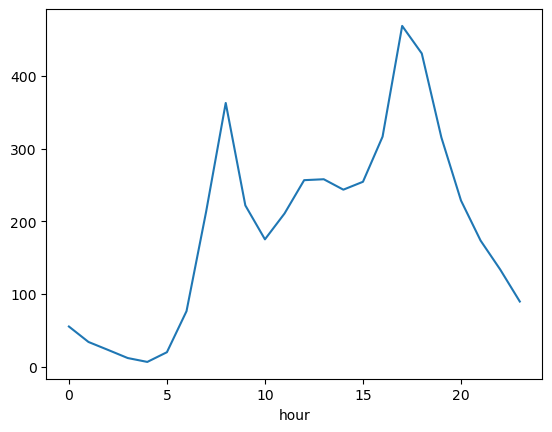

In [9]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

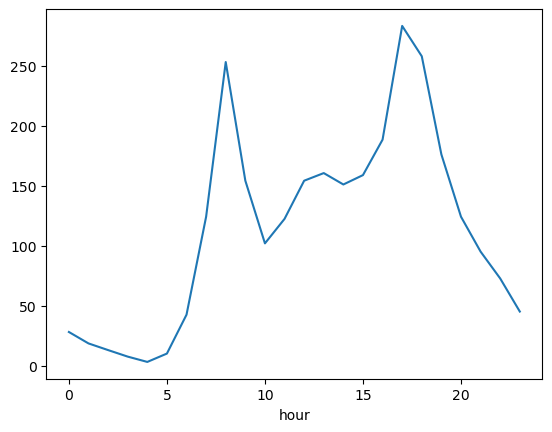

In [10]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes.season == 1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

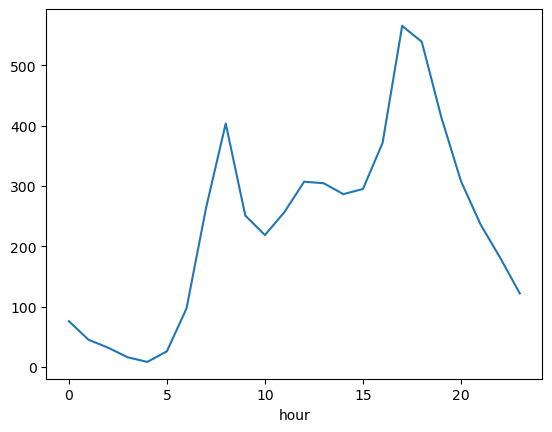

In [11]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes.season == 3].groupby('hour').total.mean().plot()

Se puede observar que al graficar el promedio de bicicletas rentadas por hora es coherente con el análisis comentado arriba respecto a que las horas donde se presenta una mayor cantidad son las 8 am, 5pm y 6pm, y las horas de menor cantidad son en la madrugada. Al analizar por temporada, se puede observar que la tendencia de las horas se mantiene pero en una menor cantidad en el invierno, puesto que es la que menos cantidad en promedio de bicicletas rentadas presenta respecto a las demás estaciones del año. En este caso, se puede observar que el verano presenta la misma tendencia respecto a las horas que el invierno, pero con cantidades totales mayores en promedio.

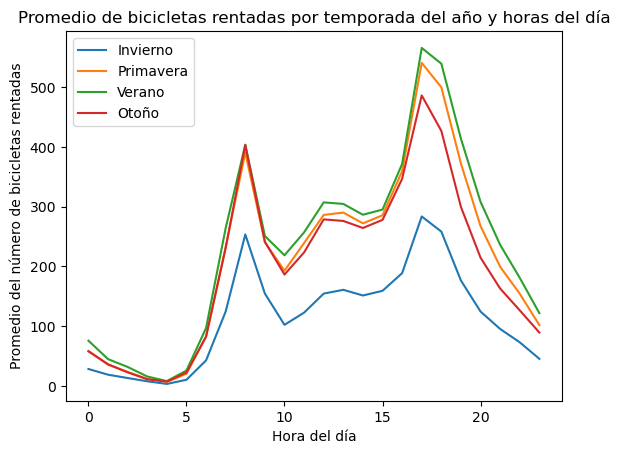

In [12]:
bikesporhouryseason = bikes.groupby(['hour', 'season'])['total'].mean()

winter = bikesporhouryseason.loc[:, 1]
spring = bikesporhouryseason.loc[:, 2]
summer = bikesporhouryseason.loc[:, 3]
fall = bikesporhouryseason.loc[:, 4]

plt.plot(winter.index, winter, label='Invierno')
plt.plot(spring.index, spring, label='Primavera')
plt.plot(summer.index, summer, label='Verano')
plt.plot(fall.index, fall, label='Otoño')

plt.xlabel('Hora del día')
plt.ylabel('Promedio del número de bicicletas rentadas')
plt.title('Promedio de bicicletas rentadas por temporada del año y horas del día')
plt.legend()
plt.show()

Realizando un análisis gráfico del promedio de cantidad de bicicletas rentadas por cada hora del día en cada temporada del año (verano, primavera, invierno y otoño), se pueden observar que tal y como se mencionó arriba, el verano es quien más cantidad registra seguidos de la primavera. También es coherente con el análisis realizado de las horas, pues se registran los mayores picos a las 8 am, 5 pm y 6pm.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [13]:
# Celda 3
# Se organizan las variables predictoras y se obtienen dummies de la categórica *season* eliminando la primera
# observación para evitar multicolinealidad
X = bikes[['hour', 'season']]
X = pd.get_dummies(X, columns=['season'], drop_first=True)
y = bikes['total']

In [14]:
# Se verifica que queden las predictoras, sin season_1 que vendría siendo invierno que es omitida en este caso.
X.columns

Index(['hour', 'season_2', 'season_3', 'season_4'], dtype='object')

In [15]:
# Se divide la muestra y se entrena el modelo en la muestra de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [16]:
# Se imprimen los coeficientes
pd.DataFrame(data= [lr.coef_], columns = lr.feature_names_in_)

,hour,season_2,season_3,season_4
0,10.489617,101.046538,119.515577,85.044514


Para darle una interpretación a cada uno de los coeficientes se debe asumir el supuesto de "Ceteris paribus", que quiere decir "manteniendo todo lo demás constante" en cada caso, de esta forma:

hour = un incremento de una unidad en la variable "hour" genera un aumento de 10.489617 unidades en la variable respuesta "total". En otras palabras, por cada hora que pasa en el día, la cantidad total de bicicletas alquiladas aumenta en 10.5 unidades en promedio.

Para entender los coeficientes season de estaciones del año, se deben comparar con el nivel base que en este caso es invierno, entonces:

season_2 = se espera que el número total de bicicletas alquiladas aumente en 101.04 unidades durante la primavera respecto al invierno.

season_3 = se espera que el número total de bicicletas alquiladas aumente en 119.5 unidades durante el verano respecto al invierno.

season_4 = se espera que el número total de bicicletas alquiladas aumente en 85 unidades durante el otoño respecto al invierno.

Algunas de las limitaciones más importantes que tiene la regresión lineal en este caso es que asume una relación lineal entre las variables predictoras y la variable de respuesta, y que asume que los errores entre las observaciones son independientes entre sí.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [17]:
# Celda 4
#Con los notebooks del curso se adecuó el siguiente programa para pronosticar la variable total la cual es contínua

#Se seleccionan las variables predictoras y la variable de respuesta, y se divide la muestra en test y train
y = bikes['total']
X = bikes[['season', 'hour']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001


# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

#Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


In [18]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol, con los 6 nodos finales especificados
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, min_leaf=6):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() 
    y_prob = y.mean() 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
    if tree['n_samples'] <= min_leaf:
        return tree
        
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, min_leaf=min_leaf)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, min_leaf=min_leaf)
    
    return tree

In [19]:
# Para que sean 6 nodos finales.
tree=tree_grow(X, y, level=0, max_depth=5)
tree

{'y_pred': 191.57413191254824,
 'y_prob': 191.57413191254824,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 55.437673900946024,
  'y_prob': 55.437673900946024,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 32.58203249442498,
   'y_prob': 32.58203249442498,
   'level': 2,
   'split': [1, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 25.177719821162444,
    'y_prob': 25.177719821162444,
    'level': 3,
    'split': [1, 2.0],
    'n_samples': 2684,
    'gain': 382.8088308604629,
    'sl': {'y_pred': 44.51045104510451,
     'y_prob': 44.51045104510451,
     'level': 4,
     'split': [0, 2.0],
     'n_samples': 909,
     'gain': 291.4004681825131,
     'sl': {'y_pred': 23.52654867256637,
      'y_prob': 23.52654867256637,
      'level': 5,
      'split': -1,
      'n_samples': 226,
      'gain': 45.41972746495435},
     'sr': {'y_pred': 51.45387994

In [20]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [21]:
# Ejecución de función tree_predict
tree_predict(X, tree)

array([ 23.52654867,  23.52654867,  22.89955357, ..., 199.39473684,
       153.79824561,  89.29824561])

In [22]:
# Para evaluar el desempeño del árbol se realizan predicciones con el arbol creado:
# Se hacen predicciones sobre el conjunto de entrenamiento y de prueba
y_train_pred = tree_predict(X_train, tree)
y_test_pred = tree_predict(X_test, tree)

# Se calcula el MSE sobre el conjunto de entrenamiento y de prueba
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Se calcula el R2 sobre el conjunto de entrenamiento y de prueba
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print('MSE en el conjunto de entrenamiento:', mse_train)
print('MSE en el conjunto de evaluación:', mse_test)
print('R2 en el conjunto de entrenamiento:', r2_train)
print('R2 en el conjunto de evaluación:', r2_test)

MSE en el conjunto de entrenamiento: 13832.965735418105
MSE en el conjunto de evaluación: 14582.057458306206
R2 en el conjunto de entrenamiento: 0.5801609315622525
R2 en el conjunto de evaluación: 0.5511420829510267


El desempeño del modelo no es muy bueno, pues tiene un alto MSE y un R2 regular en las muestras, cercano al azar, aunque levemente mayor. El modelo parece estar ligeramente sobreajustado pues presenta un menor MSE y mayor R2 en el conjunto de entrenamiento respecto al conjunto de prueba.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [23]:
# Celda 5
# La muestra está dividida en conjunto de entrenamiento y evaluación desde el punto anterior, de manera que
# solo se define el modelo para poder compararlos entre sí.
TreeRegressor= DecisionTreeRegressor()
TreeRegressor.fit(X_train, y_train)
print("El R2 del modelo en la muestra de evaluación es")
metrics.r2_score(TreeRegressor.predict(X_test), y_test)

El R2 del modelo en la muestra de evaluación es


0.3357507305984354

In [24]:
print("El R2 del modelo en la muestra de entrenamiento es")
metrics.r2_score(TreeRegressor.predict(X_train), y_train)

El R2 del modelo en la muestra de entrenamiento es


0.38721272322436207

In [25]:
print("El MSE del modelo en la muestra de evaluación es")
metrics.mean_squared_error(TreeRegressor.predict(X_test), y_test)

El MSE del modelo en la muestra de evaluación es


13465.38529268232

In [26]:
print("El MSE del modelo en la muestra de entrenamiento es")
metrics.mean_squared_error(TreeRegressor.predict(X_train), y_train)

El MSE del modelo en la muestra de entrenamiento es


12518.869213955259

El presente modelo tiene un mejor desempeño que el realizado manualmente en el punto anterior en términos del error  MSE pues es menor, pero el R2 es levemente inferior y esta métrica se busca que sea mayor. En términos generales pareciera que el modelo del punto anterior tiene mejor desempeño pues tiene un valor de R2 mayor en ambos conjuntos además de que el MSE es similar, aunque sea menor. Además, el presente modelo parece que también tiene un ligero sobreajuste pues el conjunto de entrenamiento tiene mejor desempeño en términos de MSE y R2 respecto al conjunto de evaluación.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [27]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [28]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [29]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [30]:
# Celda 6
# Adecuando los scripts de los notebooks del curso para el caso en particular
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 50)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

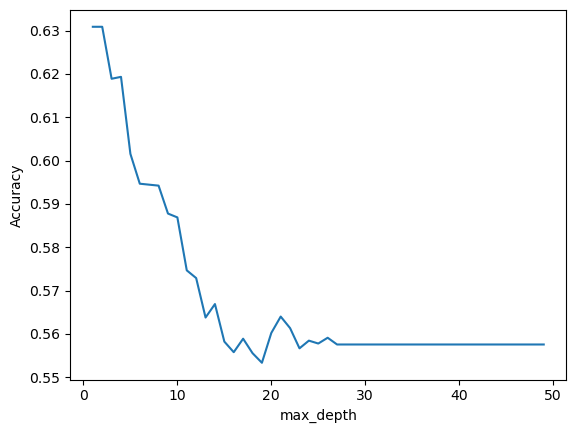

In [31]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [32]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]
# La profundidad será de 2

(0.6308888888888888, 2)

In [33]:
# Se ajusta el arbol con max_depth=2 a los datos de entrenamiento
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [34]:
# Se obtienen el F1 Score y el Accuracy del modelo para la muestra de evaluación
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6448598130841121, 0.6453333333333333)

In [35]:
# Se obtienen el F1 Score y el Accuracy del modelo para la muestra de entrenamiento
y_pred = clf.predict(X_train)
metrics.f1_score(y_pred, y_train), metrics.accuracy_score(y_pred, y_train)

(0.628956228956229, 0.6326666666666667)

In [36]:
# Impresión de resultados de desemepeño del árbol de decisión en muestra de evaluación
pd.Series(cross_val_score(clf, X_test, y_test, cv=10)).describe()

count    10.000000
mean      0.646667
std       0.035970
min       0.593333
25%       0.618333
50%       0.653333
75%       0.665000
max       0.713333
dtype: float64

In [37]:
# Impresión de resultados de desemepeño del árbol de decisión en muestra de entrenamiento
pd.Series(cross_val_score(clf, X_train, y_train, cv=10)).describe()

count    10.000000
mean      0.630889
std       0.014304
min       0.606667
25%       0.624444
50%       0.634444
75%       0.640000
max       0.653333
dtype: float64

In [38]:
# Crear y ajustar el modelo de regresión logística
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [39]:
# Se obtienen el F1 Score y el Accuracy del modelo para la muestra de evaluación
lr_pred = lr.predict(X_test)
metrics.f1_score(lr_pred, y_test), metrics.accuracy_score(lr_pred, y_test)

(0.6106254203093476, 0.614)

In [40]:
# Se obtienen el F1 Score y el Accuracy del modelo para la muestra de entrenamiento
lr_pred = lr.predict(X_train)
metrics.f1_score(y_train,lr_pred), metrics.accuracy_score(lr_pred, y_train)

(0.6053466243769822, 0.6128888888888889)

Tanto el arbol como la regresión tienen un desempeño moderado en la tarea de clasificación, ligeramente mejor que el azar. 

El desempeño del árbol en terminos de F1 Score y Accuracy Score para el conjunto de evaluación es (0.6448598130841121, 0.6453333333333333), mientras que el de la regresión logística es de (0.6106254203093476, 0.614). 

Para el conjunto de entrenamiento el F1 score y el accuracy del árbol son (0.628956228956229, 0.6326666666666667) mientras que para la regresión logística es de (0.6053466243769822, 0.6128888888888889).

El desempeño del arbol es ligéramente mejor que la regresión logística pues presenta un mayor F1 Score y mayor accuracy. El desempeño de las muestras de entrenamiento, como son ligeramente menores para ambos modelos esto podría sugerir que no hay sobreajuste en los modelos.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [41]:
# Celda 7
from sklearn.ensemble import BaggingClassifier
# 1ra muestra bagger con max_Depth =2 tal como nos dió más arriba
clf1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, bootstrap=True,
                        random_state=42, oob_score=True)
#2da muestra con min_samples_leaf=40, no se escogió ni tan grande ni tan pequeño para no causar sobreajuste
clf2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=40), n_estimators=100, bootstrap=True,
                        random_state=42, oob_score=True)
#3ra muestra con regresiones logísticas
clf3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, oob_score=True)

In [42]:
clf1.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                  n_estimators=100, oob_score=True, random_state=42)

In [43]:
clf2.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=40),
                  n_estimators=100, oob_score=True, random_state=42)

In [44]:
clf3.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100,
                  oob_score=True, random_state=42)

In [45]:
print("Accuracy primer modelo", metrics.accuracy_score(y_test, clf1.predict(X_test)))
print("Accuracy segundo modelo", metrics.accuracy_score(y_test, clf2.predict(X_test)))
print("Accuracy tercer modelo", metrics.accuracy_score(y_test, clf3.predict(X_test)))

Accuracy primer modelo 0.6446666666666667
Accuracy segundo modelo 0.662
Accuracy tercer modelo 0.6173333333333333


In [46]:
print("Accuracy primer modelo - entrenamiento", metrics.accuracy_score(y_train, clf1.predict(X_train)))
print("Accuracy segundo modelo - entrenamiento", metrics.accuracy_score(y_train, clf2.predict(X_train)))
print("Accuracy tercer modelo - entrenamiento", metrics.accuracy_score(y_train, clf3.predict(X_train)))

Accuracy primer modelo - entrenamiento 0.6337777777777778
Accuracy segundo modelo - entrenamiento 0.7253333333333334
Accuracy tercer modelo - entrenamiento 0.6188888888888889


In [47]:
print("F1 score primer modelo", metrics.f1_score(y_test, clf1.predict(X_test)))
print("F1 score segundo modelo", metrics.f1_score(y_test, clf2.predict(X_test)))
print("F1 score tercer modelo", metrics.f1_score(y_test, clf3.predict(X_test)))

F1 score primer modelo 0.6439545758183033
F1 score segundo modelo 0.661322645290581
F1 score tercer modelo 0.6126855600539811


In [48]:
print("F1 score primer modelo - entrenamiento", metrics.f1_score(y_train, clf1.predict(X_train)))
print("F1 score segundo modelo - entrenamiento", metrics.f1_score(y_train, clf2.predict(X_train)))
print("F1 score tercer modelo - entrenamiento", metrics.f1_score(y_train, clf3.predict(X_train)))

F1 score primer modelo - entrenamiento 0.6296629213483146
F1 score segundo modelo - entrenamiento 0.7241071428571428
F1 score tercer modelo - entrenamiento 0.6090722589468884


De manera independiente se evaluaron los modelos y se obtuvieron los resultados ilustrados encima, de manera que:
Para el conjunto de evaluación: 
La accuracy fue mayor para el segundo modelo con 0.662, seguido del primer modelo con 0.644 y luego el tercero con un accuracy de 0.617. El F1 score en estos modelos fue similar, de manera que el segundo modelo fue quien presentó el mayor con 0.661 seguido del primer modelo con 0.643 y luego el tercero con 0.612.
Para el conjunto de entrenamiento:
La accuracy fue mayor para el segundo modelo con 0.725, seguido del primer modelo con 0.633 y luego el tercer modelo con 0.618. El f1 score fue similar, donde el segundo modelo presentó el mayor con 0.724, seguido del primero con 0.629 y por último el tercero con 0.609.

Estos resultados sugieren que el segundo modelo es el que tiene el mejor desempeño respecto a accuracy y F1 score.
Por otro lado, parece haber sobreajuste en el segundo modelo, pues el conjunto de entrenamiento tiene mejor desempeño respecto al conjunto de evaluación, con mayor F1 score y mayor accuracy. El primer modelo no parece presentar este problema, pero el tercero tiene también una ligera diferencia en tanto el accuracy del conjunto de entrenamiento es ligeramente mayor respecto al conjunto de evaluación.

Para el segundo modelo se utilizó un valor de 40 en el parámetro min_samples_leaf que es el número mínimo de muestras en cada hoja del arbol de decisión, porque escoger un valor muy pequeño podría llevar a un modelo más complejo y propenso a sobreajuste, y uno muy alto podría convertir el modelo en algo muy simple que no capturara la complejidar de los datos, de manera que el criterio fue ese, 40, porque se consideró un punto medio entre ambos extremos.

#### Ahora, se ensamblarán con el metodo de votación mayoritaria ####

In [49]:
#Ahora para ensamblarlas se adecúa el código de los notebooks del curso con los 3 modelos en cuestión

# Realizar la predicción con los tres modelos
y_pred_model1 = clf1.predict(X_test)
y_pred_model2 = clf2.predict(X_test)
y_pred_model3 = clf3.predict(X_test)

# Obtener la votación mayoritaria
y_pred33 = (y_pred_model1 + y_pred_model2 + y_pred_model3 >= 2).astype(np.int)

# Realizar la predicción con los tres modelos - train
y_pred_model1t = clf1.predict(X_train)
y_pred_model2t = clf2.predict(X_train)
y_pred_model3t = clf3.predict(X_train)

# Obtener la votación mayoritaria - train
y_pred33t = (y_pred_model1t + y_pred_model2t + y_pred_model3t >= 2).astype(np.int)

# Evaluar el desempeño
print("F1 score ensamble votación mayoritaria", metrics.f1_score(y_test, y_pred33))
print("Accuracy ensamble votación mayoritaria", metrics.accuracy_score(y_test, y_pred33))
print("F1 score ensamble votación mayoritaria - train", metrics.f1_score(y_train, y_pred33t))
print("Accuracy ensamble votación mayoritaria - train", metrics.accuracy_score(y_train, y_pred33t))

F1 score ensamble votación mayoritaria 0.6473364801078894
Accuracy ensamble votación mayoritaria 0.6513333333333333
F1 score ensamble votación mayoritaria - train 0.6622727272727272
Accuracy ensamble votación mayoritaria - train 0.6697777777777778


Se puede observar que el modelo de ensamble con votación mayoritaria presenta un desempeño regular, donde su accuracy es levemente superior al azar. 

Se observa que para el conjunto de evaluación eñ accuracy es de 0.651 y el F1 score es de 0.647. Mientras que en el conjunto de entrenamiento, el accuracy es de 0.669 y el F1 score es de 0.662.

Estos resultados sugieren que el modelo tiene mejor desempeño en la muestra de entrenamiento, ya que presenta mayor accuracy y F1 score, de manera que se observa un ligero sobreajuste en el modelo.

Comparando con los modelos del punto anterior, para el conjunto de evaluación presenta un accuracy bueno, situandolo después del segundo modelo de mayor a menor, y en términos del F1 score pasa lo mismo, el segundo modelo sigue siendo el modelo con mejor desempeño en este conjunto de datos.
Respecto al conjunto de entrenamiento, sucede exactamente lo mismo.

En ese orden de ideas se puede decir que el segundo modelo tiene mejor desempeño que este modelo ensamblado aunque ambos presentan un ligero sobreajuste.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [50]:
# Ajustando el codigo de los notebooks con el problema en cuestión se obtiene lo siguiente
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
# Para el conjunto de evaluación
errors = np.zeros((3, clf1.n_estimators))
y_pred_all_ = np.zeros((X_test.shape[0], 3, clf1.n_estimators))

for j, clf in enumerate([clf1, clf2, clf3]):
    for i in range(clf.n_estimators):
        oob_sample = ~clf.estimators_samples_[i]
        y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
        errors[j, i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, j, i] = clf.estimators_[i].predict(X_test)
alphas = (1 - errors) / (1 - errors).sum(axis=0)
y_pred = (np.sum(y_pred_all_ * alphas, axis=(1, 2)) >= 0.5).astype(np.int)

# Ahora para el conjunto de entrenamiento se realiza lo mismo
errors = np.zeros((3, clf1.n_estimators))
y_pred_all_ = np.zeros((X_train.shape[0], 3, clf1.n_estimators))

for j, clf in enumerate([clf1, clf2, clf3]):
    for i in range(clf.n_estimators):
        oob_sample = ~clf.estimators_samples_[i]
        y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
        errors[j, i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, j, i] = clf.estimators_[i].predict(X_train)
    
alphas = (1 - errors) / (1 - errors).sum(axis=0)

y_train_pred = (np.sum(y_pred_all_ * alphas, axis=(1, 2)) >= 0.5).astype(np.int)

# Evaluar el desempeño
print("F1 score ensamble votación ponderada", metrics.f1_score(y_test, y_pred))
print("Accuracy ensamble votación ponderada", metrics.accuracy_score(y_test, y_pred))
print("F1 score ensamble votación ponderada - train", metrics.f1_score(y_train, y_train_pred))
print("Accuracy ensamble votación ponderada - train", metrics.accuracy_score(y_train, y_train_pred))

F1 score ensamble votación ponderada 0.6734966592427617
Accuracy ensamble votación ponderada 0.5113333333333333
F1 score ensamble votación ponderada - train 0.6695535314319846
Accuracy ensamble votación ponderada - train 0.5082222222222222


Se puede observar que con la metodología votación ponderada, se obtuvo un resultado levemente mayor en desempeño de F1 score y accuracy para los datos de evaluación respecto a los datos de entrenamiento, no hay indicios de sobreajuste en ese aspecto. Aunque la diferencia es mínima.

El modelo tiene un F1 score medianamente bueno con 0.67 en el conjunto de evaluación y 0.66 en el conjunto de entrenamiento, respecto a los demás modelos evaluados anteriormente es el que presenta el mayor F1 score en el conjunto de evaluación, y el segundo mayor en el conjunto de train solo después del segundo modelo.
Pero, tiene una accuracy bastante regular, muy cercano al azar. 

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

De las ventajas de los modelos de ensamblaje tal y como se vio en clase es que la probabilidad de que el ensamblaje sea correcto es mayor a la probabilidad de que cada uno de los modelos sea correcto. Para el ensamblaje con votación mayoritaria el ensamblaje final predice de acuerdo a la clase que obtuvo la mayor cantidad de votos. Y para la votación ponderada, para cada clasificador, el peso de su predicción se pondera por un valor alfa. El valor alfa depende del desempeño del modelo, de qué tan correcto predice.

Ambos modelos tienen ventajas pero en términos de desventajas se puede decir que el modelo de votación ponderada puede ser complejo en tanto se deben calibrar los pesos de cada modelo para la ponderación, considero que finalmente el objetivo es reducir los costos operacionales y si se puede llegar a definir más claramente esta métrica, todo podría ser beneficioso para este tipo de modelos.

Sería bueno conocer casos más parecidos para la realización de estos ejercicios puesto que para muchas personas puede ser un tema completamente nuevo, y para una mejor pedagogía sería claro aplicar lo que se quiere en un conjunto A de datos, para luego pasar a replicarlo a otro conjunto B entendiendo bien qué se ejecuta en cada línea de código.

Si bien el desempeño de los modelos ensamblados no fue claramente mejor que los otros, esto puede deberse a la calibración de los modelos y la forma en la que se definieron, pero en términos generales, estos ensamblajes tienen un mejor desempeño y con un conjunto de datos y valores más claros, se puede observar más claramente esta tendencia.

En el punto 7 y 8 se obtuvieron los siguientes resultados:
# Modelos individuales #
Accuracy primer modelo 0.6446666666666667

Accuracy segundo modelo 0.662

Accuracy tercer modelo 0.6173333333333333

Accuracy primer modelo - entrenamiento 0.6337777777777778

Accuracy segundo modelo - entrenamiento 0.7253333333333334

Accuracy tercer modelo - entrenamiento 0.6188888888888889

F1 score primer modelo 0.6439545758183033

F1 score segundo modelo 0.661322645290581

F1 score tercer modelo 0.6126855600539811

F1 score primer modelo - entrenamiento 0.6296629213483146

F1 score segundo modelo - entrenamiento 0.7241071428571428

F1 score tercer modelo - entrenamiento 0.6090722589468884


## Modelos ensamblados ##
#### Votación mayoritaria ####

F1 score ensamble votación mayoritaria 0.6473364801078894

Accuracy ensamble votación mayoritaria 0.6513333333333333

F1 score ensamble votación mayoritaria - train 0.6622727272727272

Accuracy ensamble votación mayoritaria - train 0.6697777777777778

#### Votación ponderada ####

F1 score ensamble votación ponderada 0.6734966592427617

Accuracy ensamble votación ponderada 0.5113333333333333

F1 score ensamble votación ponderada - train 0.6695535314319846

Accuracy ensamble votación ponderada - train 0.5082222222222222